In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [25]:
dataset_dir = 'C:/Users/Saahil/Documents/Projects/HackrX/dataset-doctor-bills'

# Preprocessing and Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescaling pixel values
    rotation_range=20,   # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.15,        # Shear transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest',     # Filling strategy
    validation_split=0.2     # Reserve 20% for validation
)

# Load and augment training data
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use this for training split
)

# Load and augment validation data
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use this for validation split
)


Found 85 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


In [26]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers to keep pre-trained weights
for layer in base_model.layers[:143]:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(512, activation='relu')(x)   # Another fully connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Final layer for binary classification

# Model compilation
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

# Evaluating the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc*100:.2f}%')

Epoch 1/20
3/3 [==============================] - 20s 5s/step - loss: 0.5856 - accuracy: 0.6118 - val_loss: 0.5442 - val_accuracy: 0.8095
Epoch 2/20
3/3 [==============================] - 12s 4s/step - loss: 0.5012 - accuracy: 0.8000 - val_loss: 0.5316 - val_accuracy: 0.8095
Epoch 3/20
3/3 [==============================] - 11s 4s/step - loss: 0.4694 - accuracy: 0.8000 - val_loss: 0.5017 - val_accuracy: 0.8095
Epoch 4/20
3/3 [==============================] - 11s 4s/step - loss: 0.4579 - accuracy: 0.8000 - val_loss: 0.4976 - val_accuracy: 0.8095
Epoch 5/20
3/3 [==============================] - 12s 4s/step - loss: 0.4119 - accuracy: 0.8118 - val_loss: 0.4941 - val_accuracy: 0.8095
Epoch 6/20
3/3 [==============================] - 12s 4s/step - loss: 0.4097 - accuracy: 0.8471 - val_loss: 0.4898 - val_accuracy: 0.8095
Epoch 7/20
3/3 [==============================] - 11s 4s/step - loss: 0.4684 - accuracy: 0.8118 - val_loss: 0.4896 - val_accuracy: 0.8095
Epoch 8/20
3/3 [==================

1/1 [==============================] - 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

      forged       0.00      0.00      0.00         4
     genuine       0.81      1.00      0.89        17

    accuracy                           0.81        21
   macro avg       0.40      0.50      0.45        21
weighted avg       0.66      0.81      0.72        21



C:\Users\Saahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Saahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Saahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

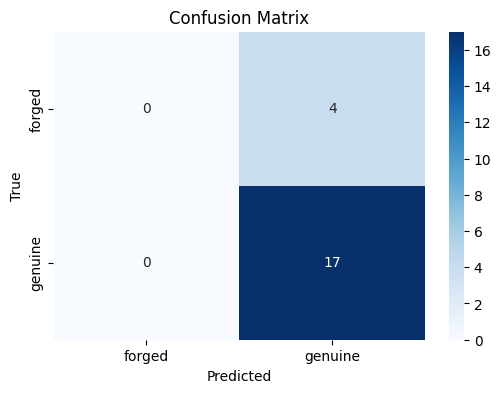

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the true labels and predicted probabilities
val_generator.reset()  # Reset the generator to start from the first batch
predictions = model.predict(val_generator)  # Get the predictions (probabilities)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Step 2: Get the true labels
true_labels = val_generator.classes  # Actual labels from validation generator

# Step 3: Print the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=val_generator.class_indices.keys()))

# Step 4: Print the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Anomaly detection approach

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width = 224, 224

# Image data generator for loading forged images
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

# Load forged documents (train on them as the normal class)
train_generator = datagen.flow_from_directory(
    'C:/Users/Saahil/Documents/Projects/HackrX/Document Forgery detection.v48i.multiclass/train',  # Path to the forged dataset folder
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode=None,  # No labels required for autoencoder
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'C:/Users/Saahil/Documents/Projects/HackrX/Document Forgery detection.v48i.multiclass/valid/',  
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode=None,
    subset='validation'
)

# Modify the autoencoder to expect both input and target as the same
def autoencoder_generator(generator):
    while True:
        batch = generator.next()  # Get the batch of images
        yield (batch, batch)  # Return the same batch as both input and target

# Create the modified generator
train_autoencoder_gen = autoencoder_generator(train_generator)
val_autoencoder_gen = autoencoder_generator(val_generator)

# Build the autoencoder model
input_img = Input(shape=(img_height, img_width, 3))  # Input image dimensions

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck (compressed representation)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer (RGB image)

# Define the autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  # Mean squared error loss for reconstruction

# Train the autoencoder using the modified generators
autoencoder.fit(
    train_autoencoder_gen,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_autoencoder_gen,
    validation_steps=len(val_generator)
)

# Define a function for anomaly detection (genuine documents)
def is_anomalous(document):
    document = np.expand_dims(document, axis=0)  # Add batch dimension
    reconstruction = autoencoder.predict(document)
    reconstruction_error = np.mean(np.abs(document - reconstruction))  # Compute reconstruction error
    threshold = 0.01  # Set threshold based on validation results
    return reconstruction_error > threshold  # Anomalous if error is greater than threshold

# Example on validation set
test_doc = val_generator[0][0]  # Get a test document
if is_anomalous(test_doc):
    print("Document is genuine (anomalous)")
else:
    print("Document is forged (normal)")


Found 710 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
Epoch 1/20
23/23 [==============================] - 24s 990ms/step - loss: 0.0680 - val_loss: 0.0425
Epoch 2/20
23/23 [==============================] - 23s 1s/step - loss: 0.0334 - val_loss: 0.0492
Epoch 3/20
23/23 [==============================] - 22s 970ms/step - loss: 0.0248 - val_loss: 0.0236
Epoch 4/20
23/23 [==============================] - 24s 1s/step - loss: 0.0191 - val_loss: 0.0262
Epoch 5/20
23/23 [==============================] - 25s 1s/step - loss: 0.0161 - val_loss: 0.0148
Epoch 6/20
23/23 [==============================] - 23s 1s/step - loss: 0.0139 - val_loss: 0.0090
Epoch 7/20
23/23 [==============================] - 21s 927ms/step - loss: 0.0123 - val_loss: 0.0089
Epoch 8/20
23/23 [==============================] - 22s 938ms/step - loss: 0.0115 - val_loss: 0.0077
Epoch 9/20
23/23 [==============================] - 22s 935ms/step - loss: 0.0109 - val_loss: 0.0073
Epoch 10/20
23/23 [===

In [29]:
# Define a function for anomaly detection (genuine documents)
def is_anomalous(document):
    document = np.expand_dims(document, axis=0)  # Add batch dimension
    reconstruction = autoencoder.predict(document)
    reconstruction_error = np.mean(np.abs(document - reconstruction))  # Compute reconstruction error
    threshold = 0.02  # Set threshold based on validation results
    return reconstruction_error > threshold  # Anomalous if error is greater than threshold


1/1 [==============================] - 0s 145ms/step
Confusion Matrix:
[[ 0 17]
 [ 0  0]]
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


C:\Users\Saahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## training both models

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Data generators for Dataset 1 (Forged only)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'C:/Users/Saahil/Documents/Projects/HackrX/Document Forgery detection.v48i.multiclass/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # No labels for one-class
)

valid_generator = datagen.flow_from_directory(
    'C:/Users/Saahil/Documents/Projects/HackrX/Document Forgery detection.v48i.multiclass/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # No labels for one-class
)

# Define a ResNet50 based model for one-class training
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)  # Flatten layer defined properly
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to stop training when validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Training only on the forged data
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=valid_generator, 
                    callbacks=[early_stopping])

# Test on the forged dataset
test_generator = datagen.flow_from_directory(
    'C:/Users/Saahil/Documents/Projects/HackrX/Document Forgery detection.v48i.multiclass/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode=None
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')


Found 887 images belonging to 1 classes.
Found 85 images belonging to 1 classes.

Epoch 1/10


28/28 [==============================] - 132s 4s/step - loss: 1.0348 - accuracy: 0.6787 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
28/28 [==============================] - 110s 4s/step - loss: 0.4506 - accuracy: 0.8794 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
28/28 [==============================] - 127s 5s/step - loss: 0.2565 - accuracy: 0.9651 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 4/10
28/28 [==============================] - 144s 5s/step - loss: 0.1740 - accuracy: 0.9707 - val_loss: 0.1264 - val_accuracy: 1.0000
Found 20 images belonging to 1 classes.
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Accuracy: 0.0000


In [4]:
# Data augmentation and ImageDataGenerator for Dataset 2
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

# Train and validation generators for forged and genuine documents
train_generator = datagen.flow_from_directory(
    'C:/Users/Saahil/Documents/Projects/HackrX/dataset-doctor-bills/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'C:/Users/Saahil/Documents/Projects/HackrX/dataset-doctor-bills/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Compute class weights for handling class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Define ResNet50-based model with custom layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the last few layers of ResNet50
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Train the model with class weights for balancing
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate model on validation data
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')


Found 165 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


NameError: name 'compute_class_weight' is not defined

## trial

In [21]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to divide an image into smaller chunks
def chunk_image(image, chunk_size):
    chunks = []
    h, w = image.shape[:2]
    for y in range(0, h, chunk_size):
        for x in range(0, w, chunk_size):
            chunk = image[y:y+chunk_size, x:x+chunk_size]
            if chunk.shape[0] == chunk_size and chunk.shape[1] == chunk_size:  # Ensure chunk is complete
                chunks.append(chunk)
    return chunks

# Preprocess and augment the data
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
    validation_split=0.3  # 30% for testing
)

# Train generator (70% of data)
train_generator = train_datagen.flow_from_directory(
    directory='C:/Users/Saahil/Documents/Projects/HackrX/dataset-doctor-bills/',
    target_size=(224, 224),  # ResNet50 input size
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='training'  # 70% for training
)

# Test generator (30% of data)
test_generator = train_datagen.flow_from_directory(
    directory='C:/Users/Saahil/Documents/Projects/HackrX/dataset-doctor-bills/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    subset='validation'  # 30% for validation/testing
)

# Load and chunk images in batches (modify flow_from_directory)
def preprocess_and_chunk_batch(batch_images, chunk_size=128):
    batch_chunks = []
    for image in batch_images:
        chunks = chunk_image(image, chunk_size)
        batch_chunks.extend(chunks)
    return np.array(batch_chunks)



Found 151 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [22]:
# Model part
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the pre-trained ResNet50 model without the top fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pooling to reduce feature dimensions
    Dense(1024, activation='relu'),  # Fully connected layers
    Dropout(0.5),  # Dropout to reduce overfitting
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification for forgery detection
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Epoch 1/50
1/1 [==============================] - 1s 591ms/step - loss: 0.2574 - accuracy: 0.8800 - val_loss: 0.0854 - val_accuracy: 1.0000
Epoch 2/50
1/1 [==============================] - 0s 483ms/step - loss: 0.2362 - accuracy: 0.9200 - val_loss: 0.0748 - val_accuracy: 1.0000
Epoch 3/50
1/1 [==============================] - 0s 494ms/step - loss: 0.2802 - accuracy: 0.8800 - val_loss: 0.0654 - val_accuracy: 1.0000
Epoch 4/50
1/1 [==============================] - 0s 473ms/step - loss: 0.2325 - accuracy: 0.8800 - val_loss: 0.0582 - val_accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - 0s 488ms/step - loss: 0.1238 - accuracy: 0.9600 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 0s 480ms/step - loss: 0.1789 - accuracy: 0.9600 - val_loss: 0.0506 - val_accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 1s 548ms/step - loss: 0.1409 - accuracy: 0.9200 - val_loss: 0.0503 - val_accuracy: 1.0000
Epoch 8/50
1/1 [====

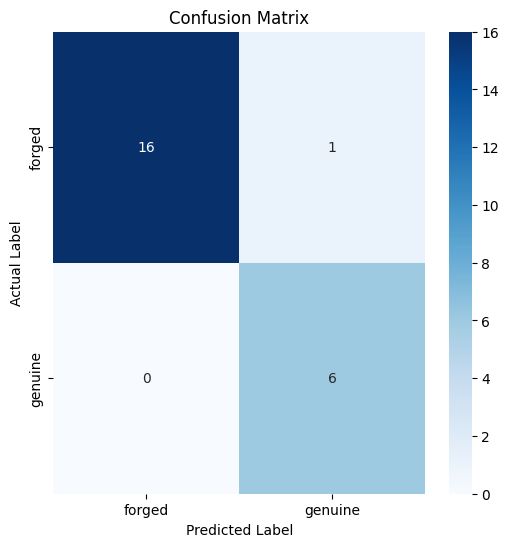

In [70]:
import matplotlib.pyplot as plt

# Train the model on image chunks
def train_on_image_chunks(generator, chunk_size=128, epochs=50,num_batch=7):
    batch=0
    for batch_images, batch_labels in generator:
        # Preprocess and chunk images
        batch_chunks = preprocess_and_chunk_batch(batch_images, chunk_size)
        batch_labels_repeated = np.repeat(batch_labels, len(batch_chunks) // len(batch_labels))  # Match the chunks
        
        # Train the model on the chunked images
        history = model.fit(
            batch_chunks, batch_labels_repeated,
            epochs=epochs,
            validation_split=0.2,  # 20% validation
            callbacks=[early_stopping]
        )
        
        batch+=1
        if(batch>num_batch):
            break
        
    return history

history = train_on_image_chunks(train_generator)

# Evaluation: Precision, Recall, Confusion Matrix
def evaluate_model(generator):
    y_true = []
    y_pred = []
    
    for batch_images, batch_labels in generator:
        # Preprocess and chunk images
        batch_chunks = preprocess_and_chunk_batch(batch_images, chunk_size=128)
        batch_labels_repeated = np.repeat(batch_labels, len(batch_chunks) // len(batch_labels))
        
        # Get predictions
        predictions = model.predict(batch_chunks)
        predicted_classes = (predictions > 0.5).astype("int32")  # Binary classification threshold
        
        # Collect true and predicted labels
        y_true.extend(batch_labels_repeated)
        y_pred.extend(predicted_classes.flatten())
        
        # Break after one batch (for demonstration purposes)
        break
    
    # Convert lists to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Print classification report (Precision, Recall, F1-Score)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['forged', 'genuine']))
    
    # Confusion Matrix
    class_mappings = list(train_generator.class_indices.keys())  # Extract class names

# Plot confusion matrix with dynamic class mappings
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mappings, yticklabels=class_mappings)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

evaluate_model(train_generator)

1/1 [==============================] - 0s 379ms/step
Classification Report:
               precision    recall  f1-score   support

      forged       0.86      0.86      0.86         7
     genuine       0.96      0.96      0.96        25

    accuracy                           0.94        32
   macro avg       0.91      0.91      0.91        32
weighted avg       0.94      0.94      0.94        32



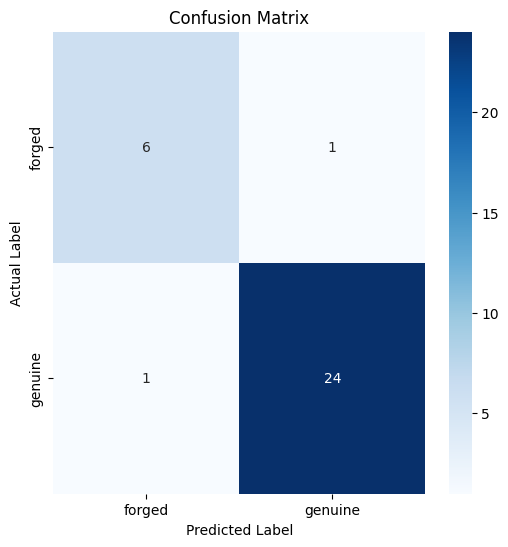

In [45]:
evaluate_model(test_generator)

In [28]:
# Print the class mappings (class labels)
print("Class mappings for training data:")
print(train_generator.class_indices)

print("\nClass mappings for testing data:")
print(test_generator.class_indices)


Class mappings for training data:
{'forged': 0, 'genuine': 1}

Class mappings for testing data:
{'forged': 0, 'genuine': 1}


In [33]:
model.save('forgery_detection_model.h5')

C:\Users\Saahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Function to divide an image into smaller chunks
def chunk_image(image, chunk_size=128):
    chunks = []
    h, w = image.shape[:2]
    for y in range(0, h, chunk_size):
        for x in range(0, w, chunk_size):
            chunk = image[y:y+chunk_size, x:x+chunk_size]
            if chunk.shape[0] == chunk_size and chunk.shape[1] == chunk_size:  # Ensure chunk is complete
                chunks.append(chunk)
    return chunks

# Load the trained model
model = load_model('forgery_detection_model.h5')

# Preprocess function for each chunk
def preprocess_chunk(chunk):
    chunk = chunk.astype(np.float32) / 255.0  # Normalize pixel values
    chunk = np.expand_dims(chunk, axis=0)  # Add batch dimension
    return chunk

# Function to predict if an image is forged or genuine based on chunk predictions
def predict_image_forgery(image_path, chunk_size=128, voting_threshold=0.5):
    # Load the image
    image = cv2.imread(image_path)
    
    # Break the image into chunks
    chunks = chunk_image(image, chunk_size)
    
    # Predict on each chunk
    chunk_predictions = []
    for chunk in chunks:
        preprocessed_chunk = preprocess_chunk(chunk)
        prediction = model.predict(preprocessed_chunk)[0][0]  # Get the prediction for this chunk (sigmoid output)
        chunk_predictions.append(prediction)

    print(chunk_predictions)
    
    # Calculate the average prediction score across all chunks
    avg_prediction_score = np.mean(chunk_predictions)
    
    # Determine if the document is forged based on the average score
    result = "Forged" if avg_prediction_score < voting_threshold else "Genuine"
    
    return result, avg_prediction_score, chunk_predictions

# Example: Test the model on a new document image
image_path = 'C:/Users/Saahil/Documents/Projects/HackrX/dataset-doctor-bills/forged/sample_6.png'
result, avg_score, chunk_scores = predict_image_forgery(image_path)

print(f"Result: {result}, Average Score: {avg_score}")


1/1 [==============================] - 0s 56ms/step
[0.2835709, 0.2835709, 0.2835709, 0.2835709, 0.2760543, 0.27823073, 0.27765417, 0.28488442, 0.2785596, 0.28367794, 0.2823341, 0.2835359, 0.2853626, 0.28130013, 0.28487417, 0.28576243, 0.28252253, 0.28001168, 0.28327492, 0.28311887, 0.28742522, 0.28855014, 0.2888598, 0.28795427]
Result: Forged, Average Score: 0.28325963020324707


In [40]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('forgery_detection_model.h5')

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Resize the image if necessary (depends on your application)
    image = cv2.resize(image, (224, 224))  # Resizing for display or consistency, if needed
    return image

# Function to make predictions on random image data
def predict_random_image(image_path, chunk_size=128, threshold=0.5):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    
    # Divide the image into chunks
    chunks = chunk_image(image, chunk_size)
    
    # Get predictions for each chunk
    predictions = []
    
    for chunk in chunks:
        # Preprocess the chunk
        preprocessed_chunk = preprocess_chunk(chunk)
        # Make the prediction
        prediction = model.predict(preprocessed_chunk)[0][0]  # Get the score for the chunk
        predictions.append(prediction)
    
    # Aggregate predictions
    avg_prediction = np.mean(predictions)
    
    # Determine the final prediction
    result = "Forged" if avg_prediction < threshold else "Genuine"
    
    return result, avg_prediction, predictions

# Example usage:
image_path = 'C:/Users/Saahil/Documents/Projects/HackrX/dataset-doctor-bills/forged/sample_6.png'  
result, avg_score, chunk_scores = predict_random_image(image_path)

print(f"Prediction Result: {result}, Average Score: {avg_score}, Chunk Scores: {chunk_scores}")


1/1 [==============================] - 1s 785ms/step
Prediction Result: Forged, Average Score: 0.2793811857700348, Chunk Scores: [0.2793812]


In [51]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Load the pre-trained ResNet50 model without the top fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # Add batch normalization
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Add callbacks to prevent overfitting and reduce learning rate dynamically
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Calculate class weights to address class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_generator.classes), y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Train the model on image chunks
def train_on_image_chunks(generator, chunk_size=128, epochs=50, num_batch=5):
    batch = 0
    for batch_images, batch_labels in generator:
        # Preprocess and chunk images
        batch_chunks = preprocess_and_chunk_batch(batch_images, chunk_size)
        batch_labels_repeated = np.repeat(batch_labels, len(batch_chunks) // len(batch_labels))
        
        # Train the model on chunked images
        history = model.fit(
            batch_chunks, batch_labels_repeated,
            epochs=epochs,
            validation_split=0.2,
            class_weight=class_weights,  # Use class weighting
            callbacks=[early_stopping, reduce_lr]
        )
        
        batch += 1
        if batch > num_batch:
            break

    return history

history = train_on_image_chunks(train_generator)



Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.9173 - accuracy: 0.4400 - val_loss: 0.7286 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - 0s 480ms/step - loss: 0.9718 - accuracy: 0.6000 - val_loss: 0.7163 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - 0s 490ms/step - loss: 0.7251 - accuracy: 0.6000 - val_loss: 0.7141 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - 0s 456ms/step - loss: 0.6827 - accuracy: 0.5600 - val_loss: 0.7211 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 5/50
1/1 [==============================] - 0s 437ms/step - loss: 0.5275 - accuracy: 0.7600 - val_loss: 0.7329 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.8000
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1/1 [==============================] - 0s 426ms/s

1/1 [==============================] - 1s 1s/step
Optimal Threshold: 0.633997917175293
Classification Report:
               precision    recall  f1-score   support

      forged       1.00      0.86      0.92        21
     genuine       0.79      1.00      0.88        11

    accuracy                           0.91        32
   macro avg       0.89      0.93      0.90        32
weighted avg       0.93      0.91      0.91        32



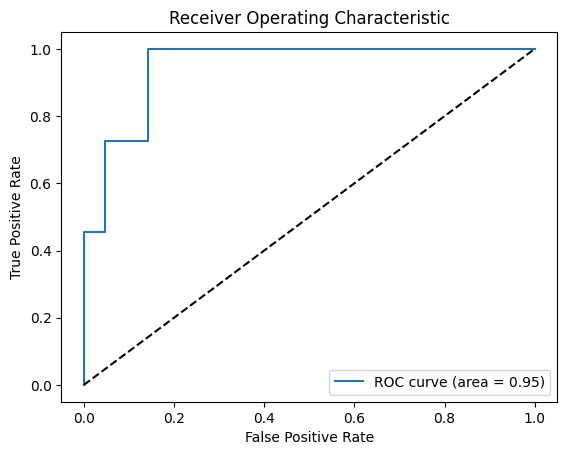

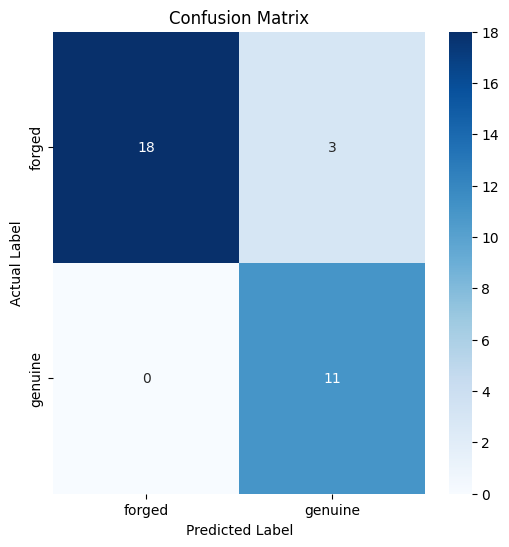

In [52]:
def evaluate_model_with_threshold(generator, optimal_threshold=0.5):
    y_true = []
    y_prob = []  # Collect probabilities for ROC-AUC curve

    for batch_images, batch_labels in generator:
        batch_chunks = preprocess_and_chunk_batch(batch_images, chunk_size=128)
        predictions = model.predict(batch_chunks).flatten()  # Get probabilities

        y_true.extend(batch_labels)
        y_prob.extend(predictions)

        break  # Limit to one batch for demonstration

    # Convert lists to arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Find optimal threshold using ROC-AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold: {optimal_threshold}")

    # Make predictions using the new threshold
    y_pred = (y_prob >= optimal_threshold).astype("int32")

    # Print classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['forged', 'genuine']))

    # Plot ROC-AUC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    class_mappings = list(train_generator.class_indices.keys())  # Extract class names
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mappings, yticklabels=class_mappings)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate the model with threshold adjustment
evaluate_model_with_threshold(train_generator)


1/1 [==============================] - 0s 367ms/step
Classification Report:
               precision    recall  f1-score   support

      forged       0.92      0.73      0.81        15
     genuine       0.80      0.94      0.86        17

    accuracy                           0.84        32
   macro avg       0.86      0.84      0.84        32
weighted avg       0.85      0.84      0.84        32



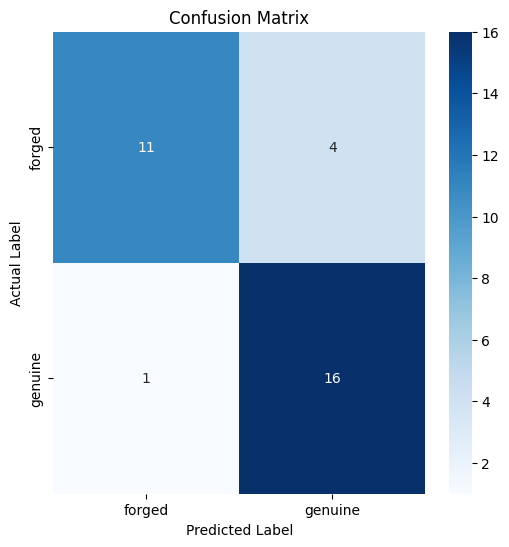

In [53]:
evaluate_model(train_generator)

1/1 [==============================] - 0s 357ms/step
Classification Report:
               precision    recall  f1-score   support

      forged       0.71      0.71      0.71         7
     genuine       0.92      0.92      0.92        25

    accuracy                           0.88        32
   macro avg       0.82      0.82      0.82        32
weighted avg       0.88      0.88      0.88        32



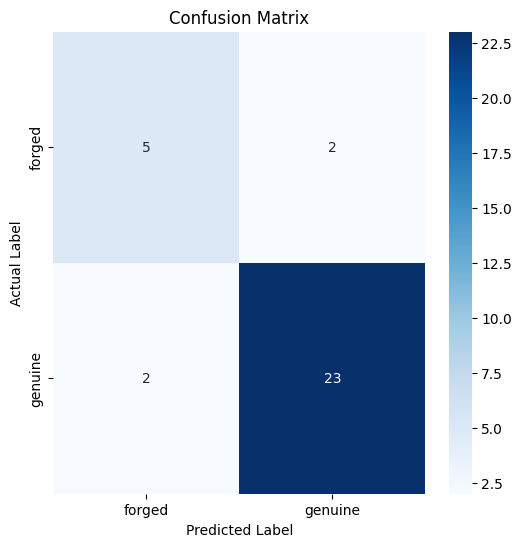

In [54]:
evaluate_model(test_generator)

In [59]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),  # Add batch normalization
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_generator.classes), y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Function to preprocess and chunk images
def preprocess_and_chunk_batch(batch_images, chunk_size):
    # Resize images to the target shape
    resized_images = [tf.image.resize(image, (128, 128)) for image in batch_images]
    # Chunking the images into smaller batches
    return np.array(resized_images)  # Return the resized images as a numpy array

# Train the model on image chunks
def train_on_image_chunks(generator, chunk_size=128, epochs=50, num_batch=5):
    batch = 0
    for batch_images, batch_labels in generator:
        # Preprocess and chunk images
        batch_chunks = preprocess_and_chunk_batch(batch_images, chunk_size)
        batch_labels_repeated = np.repeat(batch_labels, len(batch_chunks) // len(batch_labels))
        
        # Train the model on chunked images
        history = model.fit(
            batch_chunks, batch_labels_repeated[:len(batch_chunks)],
            epochs=epochs,
            validation_split=0.2 if len(batch_chunks) >= 5 else 0,  # Only use validation split if there are enough samples
            class_weight=class_weights,
            callbacks=[early_stopping, reduce_lr]
        )
        
        batch += 1
        if batch >= num_batch:
            break

    return history

history = train_on_image_chunks(train_generator)

# Evaluate the model
def evaluate_model(generator):
    y_true = []
    y_pred = []
    
    for batch_images, batch_labels in generator:
        # Preprocess and chunk images
        batch_chunks = preprocess_and_chunk_batch(batch_images, chunk_size=128)
        batch_labels_repeated = np.repeat(batch_labels, len(batch_chunks) // len(batch_labels))
        
        # Get predictions
        predictions = model.predict(batch_chunks)
        predicted_classes = (predictions > 0.5).astype("int32")  # Binary classification threshold
        
        # Collect true and predicted labels
        y_true.extend(batch_labels_repeated)
        y_pred.extend(predicted_classes.flatten())
    
    # Convert lists to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Print classification report (Precision, Recall, F1-Score)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['forged', 'genuine']))
    
    # Confusion Matrix
    class_mappings = list(train_generator.class_indices.keys())  # Extract class names

    # Plot confusion matrix with dynamic class mappings
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mappings, yticklabels=class_mappings)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()



Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.7257 - accuracy: 0.6111 - val_loss: 0.7112 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - 0s 418ms/step - loss: 0.4462 - accuracy: 0.7778 - val_loss: 0.6766 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - 0s 429ms/step - loss: 0.4675 - accuracy: 0.8333 - val_loss: 0.6482 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - 0s 416ms/step - loss: 0.4109 - accuracy: 0.7778 - val_loss: 0.6259 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 5/50
1/1 [==============================] - 0s 394ms/step - loss: 0.3614 - accuracy: 0.8333 - val_loss: 0.6084 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 6/50
1/1 [==============================] - 0s 431ms/step - loss: 0.4089 - accuracy: 0.8333 - val_loss: 0.5933 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 7/50
1/1 [==============================] - 0s 442ms/st

In [60]:
evaluate_model(train_generator)


1/1 [==============================] - 0s 445ms/step


KeyboardInterrupt: 

In [64]:
from tensorflow.keras.models import load_model
model = load_model('forgery_detection_model.h5')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 145ms/step
Highlighted Regions (Contours): [
    {
        "contour": [
            {
                "x": 1692,
                "y": 2823
            },
            {
                "x": 1692,
                "y": 2849
            },
            {
                "x": 1691,
                "y": 2850
            },
            {
                "x": 1672,
                "y": 2850
            },
            {
                "x": 1672,
                "y": 2876
            },
            {
                "x": 1671,
                "y": 2877
            },
            {
                "x": 1653,
                "y": 2877
            },
            {
                "x": 1653,
                "y": 2904
            },
            {
                "x": 1652,
                "y": 2905
            },
            {
                "x": 1439,
                "y": 2905
            },
            {
                "x": 1439,
                "y": 2959

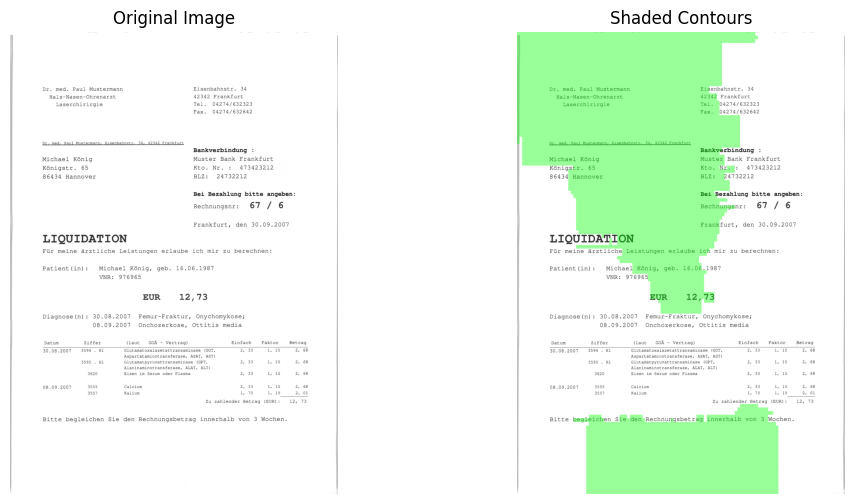

In [77]:
import numpy as np
import cv2
from lime import lime_image
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import json

# Load the trained model
model = load_model('forgery_detection_model.h5')

# Preprocessing function for input images
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    resized_img = img.resize((128, 128))
    img_array = np.array(resized_img) / 255.0
    return np.expand_dims(img_array, axis=0), img.size

# Prediction function for LIME
def predict_fn(images):
    images = np.array(images)
    return model.predict(images)

# Initialize LIME's ImageExplainer
explainer = lime_image.LimeImageExplainer()

# Path to the test image
img_path = 'C:/Users/Saahil/Documents/Projects/HackrX/dataset-doctor-bills/genuine\genuine-type02-040.png'

# Preprocess the image and get original size
img_processed, original_size = preprocess_image(img_path)
img_for_viz = img_processed[0]  # Remove batch dimension for visualization

# Generate LIME explanation for the image
explanation = explainer.explain_instance(
    img_for_viz,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Get the top predicted label dynamically
label_to_explain = explanation.top_labels[0]

# Get the mask from LIME
_, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=5,
    hide_rest=True
)

# Upsample mask to original image size
upsampled_mask = cv2.resize(mask.astype(np.uint8), original_size, interpolation=cv2.INTER_NEAREST)

# Find contours of the highlighted regions in the mask
contours, _ = cv2.findContours(upsampled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract full coordinates of each contour
regions = []
for contour in contours:
    contour_points = [{"x": int(point[0][0]), "y": int(point[0][1])} for point in contour]
    regions.append({"contour": contour_points})

# Save coordinates to JSON-like format
regions_json = json.dumps(regions, indent=4)
print("Highlighted Regions (Contours):", regions_json)

# Save the JSON to a file
with open('highlighted_regions_contours.json', 'w') as f:
    f.write(regions_json)

# Plot original and shaded image side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(Image.open(img_path))
ax[0].axis('off')
ax[0].set_title('Original Image')

# Create a blank image to overlay shading
shaded_img = cv2.imread(img_path).copy()

# Overlay the shaded regions
for contour in contours:
    # Fill the contour with a semi-transparent color
    cv2.fillPoly(shaded_img, [contour], color=(0, 255, 0))  # Green fill

# Create an alpha channel for transparency
alpha = 0.4  # Transparency factor
cv2.addWeighted(shaded_img, alpha, cv2.imread(img_path), 1 - alpha, 0, shaded_img)

# Convert BGR (OpenCV) to RGB for matplotlib
ax[1].imshow(cv2.cvtColor(shaded_img, cv2.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title('Shaded Contours')

plt.show()
